In [1]:
import sys
sys.path.insert(0,"../python/")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import scipy
from scipy.integrate import odeint
import scipy.special as sp

import math

from MC_Plots import style






In [2]:
ps = style(figure_width = 9,spine_color= 'Black')
ps2 = style(figure_width = 15,spine_color= 'Black')

In [3]:
from astropy.io import fits # If this yields an ImportError, go to your terminal and tell it `conda install astropy`

In [112]:
def extract_column(f, column_index):
    '''
    Give the fits file and the column index that you want to extract.
    '''
    d = f[column_index]
    arr = np.array(d.data)
    cols = d.columns.names

    # Either one L value or a range
    # Take the average if it is a range
    if 'ELL' not in cols:
        if 'LMIN' in cols and 'LMAX' in cols:
            arr['ELL'] = 0.5 * (arr['LMIN'] + arr['LMAX'])
        else:
            raise ValueError('Error: did not find ELL or LMIN and LMAX in columns.')
    x = arr['ELL']
    y = arr['D_ELL']
    
    # Depending on the data, the error is two-sided or not.
    if 'ERR' in cols:
        dy = (arr['ERR'], arr['ERR'])
    elif 'ERRUP' in cols and 'ERRDOWN' in cols:
        dy = (arr['ERRDOWN'], arr['ERRUP'])
    else:
        raise ValueError('Error: did not find ERR or ERRUP and ERRDOWN in columns.')
    
    return x, y, dy
    

In [113]:
def extract_data(f, indices = (1, 7)):
    # First extract all outputs
    xydys = []
    for index in indices:
        xydys.append(extract_column(f, index))
    x = np.concatenate([xydy[0] for xydy in xydys])
    y = np.concatenate([xydy[1] for xydy in xydys])
    dydown = np.concatenate([xydy[2][0] for xydy in xydys])
    dyup = np.concatenate([xydy[2][0] for xydy in xydys])
    dy = (dydown, dyup)
    return x, y, dy

In [114]:
def read_curve(fn):
    '''
    Function for reading files produced by WebPlotDigitizer
    https://apps.automeris.io/wpd/
    '''
    def stringformatter(s):
        s = str(s)
        s = s.replace(';', '')
        s = s.replace(',', '.')
        s = s.replace("b'", '')
        s = s.replace("'", '')
        return s
    d = np.loadtxt(fn, converters={i: stringformatter for i in (0,1)})
    return d[:, 0], d[:, 1]

## PLANCK PLOT##

In [115]:
fits_fn = 'Data_DM_plots/CMB/COM_PowerSpect_CMB_R2.02.fits'
f = fits.open(fits_fn)
x,y, dy = extract_data(f)

In [116]:
theory = np.loadtxt('Data_DM_plots/CMB/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt')

In [117]:
xt = theory[:, 0]
yt = theory[:, 1]

In [118]:
xt1, yt1 = read_curve('Data_DM_plots/CMB/teves_no_sterile_neutrino.txt')
xt2, yt2 = read_curve('Data_DM_plots/CMB/teves_with_sterile_neutrino.txt')

In [119]:
def shift(arr, n):
    '''
    Shift an array. Used in moving average filter
    '''
    if n == 0:
        return np.array(arr)
    if n < 0:
        return np.concatenate([np.ones(-n) * arr[0], arr[:n]])
    if n > 0:
        return np.concatenate([arr[n:], np.ones(n) * arr[-1]])
    
def mv_avg(arr, order=1):
    return np.average([shift(arr, n) for n in np.arange(-order, order + 1, 1)], axis=0)

In [120]:
# yt1 = mv_avg(yt1, 1)

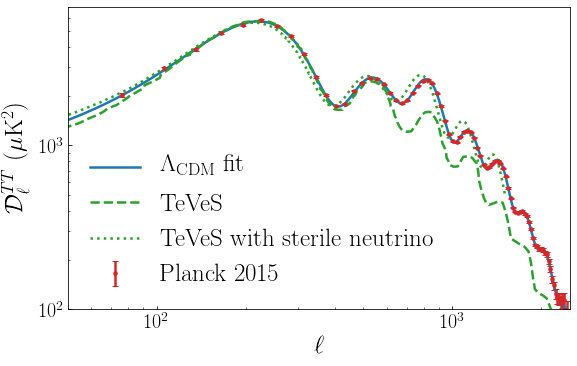

In [121]:
ps.latexify()
fig , ax=plt.subplots(1,1)



show_inset = False
error_mult = 1
lw = 2.5

#fig = plt.figure()
ax.plot(xt, yt, label=r'$\Lambda_{\rm CDM}$ fit', lw=lw)
ax.errorbar(x, y, error_mult * np.array(dy), marker='.', markersize=7, ls='None', label='Planck 2015', 
             color='C3', lw=lw)
ax.plot(xt1, mv_avg(yt1, 1), color='C2', ls='--', label='TeVeS', lw=lw)
ax.plot(xt2, mv_avg(yt2, 0), color='C2', ls='dotted', label='TeVeS with sterile neutrino', lw=lw)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(50, 2500)
ax.set_ylim(100, 7e3)
ax.legend(frameon=False)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\mathcal{D}^{TT}_{\ell}$ ($\mu$K$^2$)')
ps.format_axes(ax)

# xticks = [50, 100, 300, 1000, 2500]
# yticks =  [100, 300, 1000, 3000, 7000]
# plt.xticks(xticks, xticks)
# plt.yticks(yticks, yticks)
        
plt.savefig('DM_plots/planck.pdf', bbox_inches='tight')

## Rotation Curves ##

In [122]:
d = {}
fns = ['fit', 'pts', 'pts+', 'pts-', 'halo', 'gas', 'stellar_disk', 'luminous+', 'luminous-']
for fn in fns:
    d[fn + '_x'], d[fn] = read_curve('Data_DM_plots/rotation_curve/%s.txt' % fn)

In [123]:
d['dpts'] = (d['pts+'] - d['pts-']) * 0.5

In [124]:
for fn in ['gas', 'stellar_disk', 'halo', 'fit', 'luminous+', 'luminous-']:
    d[fn + '_x'] = np.concatenate([[0], d[fn + '_x']])
    d[fn] = np.concatenate([[0], d[fn]])

In [125]:
xp = np.linspace(0, 16, 200)
d['x'] = xp
d['baryons'] = np.sqrt(np.interp(xp, d['gas_x'], d['gas'])**2 + np.interp(xp, d['stellar_disk_x'], d['stellar_disk'])**2)
d['all'] = np.sqrt(
    np.interp(xp, d['gas_x'], d['gas'])**2 + 
    np.interp(xp, d['stellar_disk_x'], d['stellar_disk'])**2 + 
    np.interp(xp, d['halo_x'], d['halo'])**2)

for pol in ('+', '-'):
    d['lum%s' % pol] = np.interp(xp, d['luminous%s_x' % pol], d['luminous%s' % pol])

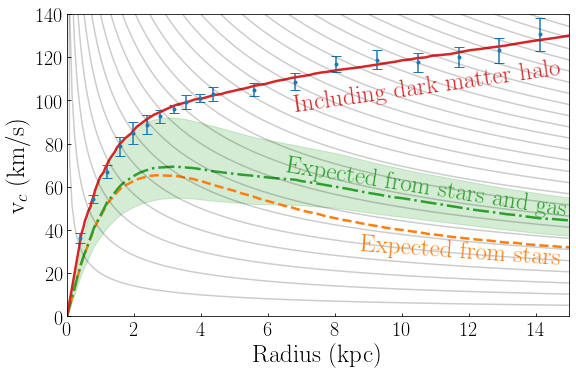

In [127]:
ps.latexify()
fig , ax=plt.subplots(1,1)

ax.errorbar(d['pts_x'], d['pts'], d['dpts'], marker='.', capsize=5, ls='None', label='Measured')
ax.plot(d['stellar_disk_x'], d['stellar_disk'], label='Stars', ls='--', lw=2.5)
ax.plot(d['x'], d['baryons'], label='Stars and gas', ls='-.', lw=2.5)
ax.plot(d['fit_x'], d['fit'], label='Stars, gas and dark matter', lw=2.5)

ax.set_xlabel(r'Radius (kpc)')
ax.set_ylabel(r'v$_c$ (km/s)')
ax.set_ylim(0, 140)
ax.set_xlim(0, 15)
ax.text(8.75, 30, 'Expected from stars', color='C1', rotation = -4)
ax.text(6.5, 66.5, 'Expected from stars and gas', color='C2', rotation = -9)
ax.text(6.75, 112, 'Including dark matter halo', color='C3', rotation = 8)

ax.fill_between(d['x'], d['lum-'], d['lum+'], color='C2', alpha=0.2)

xp = np.linspace(0.001, 15, 200)
for start in np.arange(20, 701, 20):
    ax.plot(xp, start * np.sqrt(1/xp), color='k', alpha=0.2, lw=1.5)

ps.format_axes(ax)

plt.savefig('DM_plots/rotationcurve.pdf', bbox_inches='tight')

## Freeze out##

In [128]:
def neq(m, T):
    # Equilibrium number density in the universe
    # Equation 3.6 from Dodelson
    def E(p):
        return np.sqrt(m**2 + p**2)
    # Use approximations if applicable
    if m/T > 1e2:
        intresult = (m *T / (2 * np.pi))**(3/2) * np.exp(-m / T)
    if m/T < 1e-2:
        intresult = T**3 / (np.pi**2)
    else:
        intresult = scipy.integrate.quad(lambda p: 1/(2 * np.pi**2) * p**2 * np.exp(- E(p) / T), 0, np.inf)[0]
    return intresult

In [129]:
def yeq(x):
    # Equilibrium comoving density Y = n/T^3 as a function of x = m/T
    # All this is independent of m, so we set it to one!
    m = 1
    T = m / x
    n = neq(m, T)
    return n / T**3

In [130]:
# This is the differential equation 3.52 in Dodelson, giving Y as a function of time parameter.
# Why time parameter? Because the time of freezeout depends on the mass of the particle.
# We solve it numericaly because in general you have to
def model(y, x, labda):
    dydx = - labda / x**2 * (y**2 - yeq(x)**2)
    return dydx
# The initial density is equal to the equilibrium density
# 1e-3 is when there is still pretty nearly equilibrium
y0 = yeq(1e-3)

In [131]:
def get_omega(sigmav):
    # Get the freezeout density TODAY, when sigmav is entered in cm**2
    # Equation 3.60 Dodelson
    xf = 10
    gstar = 100
    h = 0.7
    return 0.3 * h**(-2) * (xf/10) * (gstar / 100)**(0.5) * 10**-39 / sigmav

def get_lambda(sigma, wimp_mass = 10):
    # Get the value of lambda for the differential equation 3.52
    # enter sigma in cm**2 and wimp mass in GeV
    sigmav = sigma * (50761)**2 # to get from cm**2 to eV-2
    m = wimp_mass * 1e9 #eV
    return m**3 * sigmav / H(m)

def H(T):
    '''
    The Hubble parameter as function of temperature, returned in units of 1/eV
    '''
    gstar = 100
    alphaG = 1.752e-45
    me = 511e3 #eV
    G = alphaG / (me**2) # 1/ev*2
    # G = 1 # https://en.wikipedia.org/wiki/Natural_units
    return T**2 * np.sqrt(8 * np.pi**3 * G * gstar / 45) # units 1/eV

In [132]:
def labelplotter(X, Y, xloc, yshift, sigma, omega):
    # Plot Omega on top of the line at location xloc
    x = X[np.argmin(np.abs(X - xloc))]
    y = Y[np.argmin(np.abs(X - xloc))]
    y = y * yshift
    if omega < 0.1:
        plt.text(x, y, '$\Omega_{\chi} = $%.3f' % (omega))
    elif omega < 1:
        plt.text(x, y, '$\Omega_{\chi} = $%.2f' % (omega))
    else:
        plt.text(x, y, '$\Omega_{\chi} = $%.1f' % (omega))

In [133]:
def get_sigmalabel(sigma):
    # Nicely format the value of sigma into a cool label
    exponent = np.floor(np.log10(sigma))
    sigmalabel = r'$\sigma = $%.1f$\times$10$^{%d}$ cm$^{2}$' % (sigma / (10**(exponent)), exponent)
    return sigmalabel

In [134]:
import matplotlib as mpl
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))

In [135]:
wimp_mass = 100 # GeV

In [136]:
X = np.logspace(-3, 5, 200)
sigmas = [2e-40, 2e-39, 2e-38]
omegas = [get_omega(sigma) for sigma in sigmas]
lambdas = [get_lambda(sigma, wimp_mass) for sigma in sigmas]
ys = [odeint(model, y0, X, args = (labda,)) for labda in lambdas]
lws = [2.5, 4, 2.5]

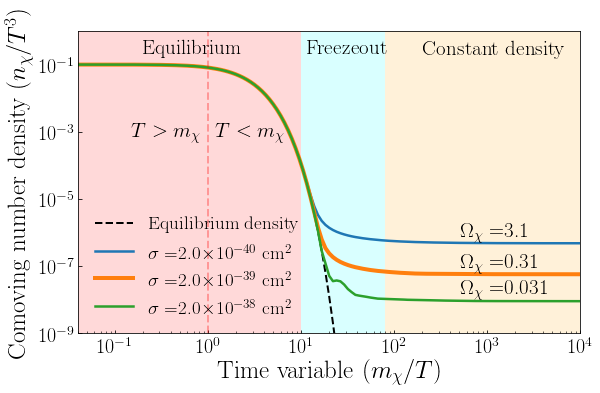

In [137]:
ps.latexify()
fig , ax=plt.subplots(1,1)
ps.format_axes(ax)

plt.rc('font', size=21)


ax.plot(X, [yeq(x) for x in X], label='Equilibrium density', color='black', ls='--', lw=2)
for y, omega, sigma, lw in zip(ys, omegas,sigmas, lws):
    plt.plot(X, y, label = get_sigmalabel(sigma), lw = lw)
    labelplotter(X, y, 500, 1.3, sigma, omega)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1)
ax.set_xlim(4e-2, 1e4)
ax.set_xlim()
ax.set_xlabel('Time variable ($m_{\chi} / T$)')
ax.set_ylabel('Comoving number density ($n_{\chi} / T^3$)')
x0 = 10
x1 = 80
draw_box((1e-2, x0), (1e-11, 1), facecolor='red', alpha=0.15)
draw_box((x0, x1), (1e-11, 1), facecolor='cyan', alpha=0.15)
draw_box((x1, 1e5), (1e-11, 1), facecolor='orange', alpha=0.15)
plt.legend(loc='lower left',frameon=False,fontsize=19)
yt = 0.3
ax.text(0.2, yt-0.1, 'Equilibrium')
ax.text(11.5, yt-0.1, 'Freezeout')#, rotation=-90)
ax.text(200, yt-0.1, 'Constant density')
ax.text(0.15, 0.0006, r'$T > m_{\chi}$')
ax.text(1.2, 0.0006, r'$T < m_{\chi}$')
ax.axvline(1, color='red', lw=2, ls='--', alpha=0.3)
plt.savefig('DM_plots/freezeout.pdf', bbox_inches='tight')

## Rates Xenon & Argon ##

In [138]:
def L_to_p(l, mode='hbar'): 
    '''
    convert momentum in fm to MeV/c 
    '''
    if mode == 'hbar':
        hc = 1973       # hBARc, in evAngstrom
    elif mode== 'h':
        hc = 12398.4193 # hRc, in evAngstrom
    else:
        raise SyntaxError('Mode not understood, please give h or hbar')
    p = hc*1e5/(l*1e6) # p in fm

    return p

In [139]:
def p_to_L(p, mode='hbar'): 
    '''convert momentum in MeV/c to fm'''
    if mode == 'hbar':
        hc = 1973       # hBARc, in evAngstrom
    elif mode== 'h':
        hc = 12398.4193 # hRc, in evAngstrom
    else:
        raise SyntaxError('Mode not understood, please give h or hbar')
    l = hc*1e5/(p*1e6) # l in fm

    return l

In [140]:
def F2_WoodsSaxon(q,A):
    '''
    # calculate the Woods-Saxon form factor
    # Equation 4.7 in Lewin and Smith, Review of mathematics ...

    # input: q - Momentum transfer
    #        A - atomic mass of the target
    #
    # return: F2 - F(q)^2
    '''
    
    # Nuclear size
    R = 1.2*A**(1./3)
    # 'nuclear skin thickness'
    s = 1 # fm
    R1 = math.sqrt(R**2-5*s**2)

    x  = R1/p_to_L(q)
    # sperical Bessel function j1(qR)
    j1 = scipy.special.spherical_jn(n=1,z=x)

    F2 = (3*j1/x)*math.exp(-(s/p_to_L(q))**2)
    F2 = F2**2
    return F2

In [141]:
def sigma_WIMP_nucleus(**kwargs):
    """    
    Arguments for WIMP-nucleus cross section calculator

    INPUT:
    :param kwargs:
       sigma_SI - spin independent WIMP-nucleon cross-section
       mWIMP    - WIMP mass
       mN       - target mass
       
    RETURN:
       sigma    - WIMP nucleus cross-section
    """
    sigma_SI = kwargs.pop('sigma_SI', 1)
    mWIMP    = kwargs.pop('mWIMP', 100)
    mN       = kwargs.pop('mN', 100)  
    
    mp = 1 # nucleon mass in GeV/c2
    mu = mN*mWIMP/(mN+mWIMP)
    
    return sigma_SI*mu**2*mN**2/mp

In [142]:
def rcalc(mWIMP,mN):
    # calculate r
    return 4*mWIMP*mN/(mWIMP+mN)**2

In [143]:
def maxE(mWIMP, mN):
    vesc = 544e3 / 299792458 # in fraction of c
    E0 = 0.5 * mWIMP * vesc**2 * 1e6 # 1e6 for GeV to keV
    r = rcalc(mWIMP, mN)
    return r * E0

In [144]:
def intrate(Er, rates, mWIMP, mN, Emin=0):
    Emax = maxE(mWIMP, mN)
    dE = np.unique(np.diff(Er))[0] # assumes uniform spacing
    bools = (Er >= Emin) & (Er <= Emax)
    return np.sum(rates * bools) * dE

In [145]:
def Rpro(E,**kwargs):
    """    
    Recoil rate calculator.
    Optional to take into account: velocity of the earth, escape velocity, form factor
    Should revert to R(E) for vE->0, vesc -> inf, and form factor off, but somehow has a factor mN in between.

    INPUT:
    E     - recoil energy (keV)
    :param kwargs:
       R0    - 0th order rate ()
       mWIMP - WIMP mass (GeV/c2)
       mN    - nucleus mass (GeV/c2)
       v0    - most probable velocity (km/s)
       vE    - earth velocity
       vesc  - escape velocity
       dof2  - boolean to turn form factor off or on (default is off)
       
    RETURN:
       dRdE(E)
    """
    R0    = kwargs.pop('R0', 1)
    mWIMP = kwargs.pop('mWIMP', 100)
    mN    = kwargs.pop('mN', 100)
    v0    = kwargs.pop('v0', 220)    
    vE    = kwargs.pop('vE', 232)
    vesc  = kwargs.pop('vesc', 544)    
    dof2  = kwargs.pop('dof2',False)    
    
    v0=v0/3e5  # in units of c
    vesc=vesc/3e5
    vE=vE/3e5
    E0=mWIMP*v0**2/2*1e6 # in units of keV
    

    mu = mN*mWIMP/(mN+mWIMP)
    r  = rcalc(mWIMP,mN)

    vmin = np.sqrt(2*E/(mWIMP*r*1e6))
    E0=mWIMP*v0**2/2*1e6
    
    # normalization factor K
    vv   = vesc/v0
    vv2  = vesc**2/v0**2
    sqpi = np.sqrt(np.pi)
    # Equation 2.2 Lewin and Smith, with K = k0 / k1
    K = 1./(math.erf(vv)-2/sqpi*vv*np.exp(-vv2))
    x1 = (vmin+vE)/v0
    x2 = (vmin-vE)/v0
    # 3.13 in Lewin and Smith
    R = K*R0/(r*E0)*(sqpi*v0/(4*vE)*(math.erf(x1)-math.erf(x2))-np.exp(-vv2))
    
    # calculate form factor
    if dof2:
        q = math.sqrt(2*mN*E)
        F2 = F2_WoodsSaxon(q,mN)
    else:
        F2 = 1.0
    R = R*F2
    # R = R*F2*mN                  
    return R

In [146]:
def R(E, **kwargs):
    '''
    Basic rate equation.
    
    INPUT:
    E     - recoil energy (keV)
    :param kwargs:
       R0    - 0th order rate ()
       mWIMP - WIMP mass (GeV/c2)
       mN    - nucleus mass (GeV/c2)
       v0    - most probable velocity (km/s)
       
    RETURN:
       dRdE(E)
    '''
    R0    = kwargs.pop('R0', 1)
    mWIMP = kwargs.pop('mWIMP', 100)
    mN    = kwargs.pop('mN', 100)
    v0    = kwargs.pop('v0', 220)    
    
    v0=v0/3e5  # in units of c
    E0=mWIMP*v0**2/2*1e6 # in units of keV
    
    mu = mN*mWIMP/(mN+mWIMP)
    r  = rcalc(mWIMP,mN)
    E0=mWIMP*v0**2/2*1e6
    R = R0/(r*E0)*np.exp(-E/(E0*r))
    return R

In [147]:
def Rate0(mN, rho, sigma_SI, v0, mWIMP, mass_unit = 'g', time_unit='s'):
    '''
    Input:
        mN     - g/mol
        rho    - GeV/cm^3
        sigma0 - cm^2
        mWIMP  - GeV
        v0     - km/s
        sigma_SI
    
    Equation 3.1 in Lewin and Smith
    '''
    # Initial reshaping
    N0 = 6.022e23 # 1/mol
    v0 = v0 * 1000 * 100 # from km/s to cm/s
    
    # Calculation of sigma0 in terms of the SI cross section
    sigma0 = sigma_WIMP_nucleus(sigma_SI = sigma_SI, mWIMP=mWIMP, mN=mN)
    
    # Basic equation
    rate = 2 / (np.sqrt(np.pi)) * N0 / mN * rho / mWIMP * sigma0 * v0
    
    if mass_unit == 'g':
        rate = rate
    elif mass_unit == 'kg':
        rate = rate * 1000
    elif mass_unit == 'ton':
        rate = rate * 1e6
    elif mass_unit == 'kton':
        print('Nice detector, dude!')
        rate = rate * 1e9
    else:
        print('Warning: unrecognized mass unit, reverting to g')
    
    if time_unit == 's':
        rate = rate
    elif time_unit == 'day':
        rate = rate * 86400
    elif time_unit == 'year':
        rate = rate * 86400 * 365
    else:
        print('Warning: unrecognized time unit, reverting to s')
        
    return rate
    

In [148]:
def RR(Er, mN= 131, mWIMP = 100, sigma_SI = 1e-45, mass_unit='ton', time_unit='year', dof2=True):
    '''
    Get the differential rate for a list of recoil energies Er.
    '''
    diffrate = []
    for E in Er:
        # Normalization
        # sigma_SI = 1
        # sigma = sigma_WIMP_nucleus(sigma_SI=sigma_SI,mN=mN,mWIMP=mWIMP)
        # Don't know why
        R0 = Rate0(mN, rho = 0.3,v0=220, mWIMP=mWIMP, sigma_SI = sigma_SI, mass_unit=mass_unit, time_unit=time_unit)
        # Compute final rate and get result
        diffrate.append(Rpro(E,R0=R0,mWIMP=mWIMP,mN=mN,v0=220,vesc=544,vE=220,dof2=dof2))
    return np.array(diffrate)

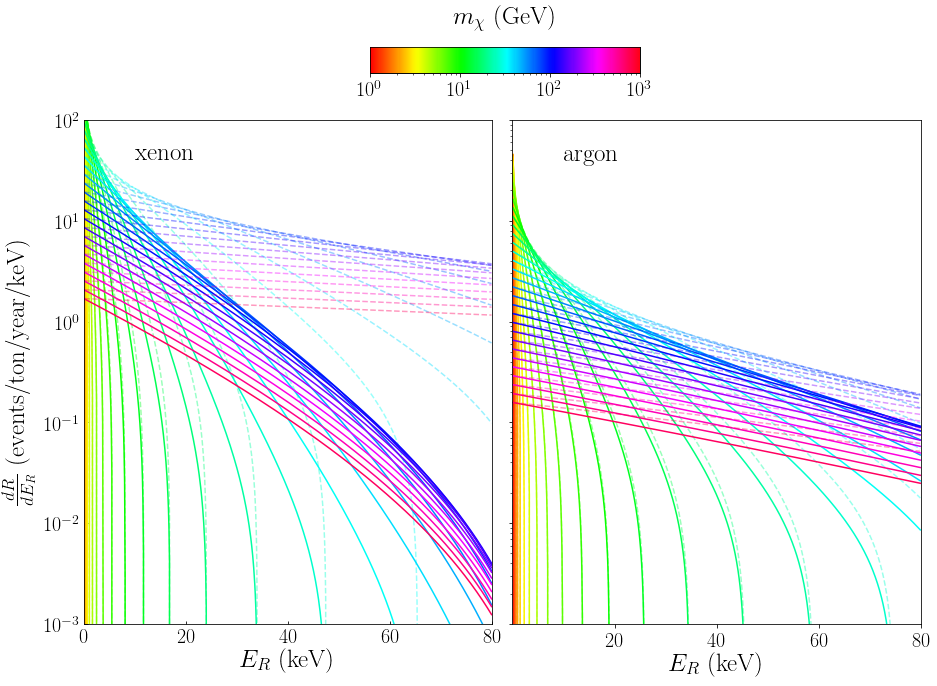

In [149]:
# Ratio of 1.0/0.85 is the plot width ratio in the thesis, so should give the same text size.
#f = plt.figure(figsize=(10 * 1.0 / 0.85, 6.0))

ps2.latexify()
fig , axes =plt.subplots(ncols=2,nrows=1,sharey=True)


xmax = 80
colormax = 0.95
Er=np.arange(0.1 ,xmax, 0.1)
mWIMPs = np.logspace(0, np.log10(1000), 35)
num_plots = len(mWIMPs)
colormap = plt.cm.hsv
colors = [colormap(i) for i in np.linspace(0, colormax, num_plots)]

gs = gridspec.GridSpec(1, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
axes = [ax0, ax1]



for ax, mN, title in zip(axes, [131, 40], ['xenon', 'argon']):
    plt.sca(ax)
   
    for i, mWIMP in enumerate(mWIMPs):
        plt.plot(Er, RR(Er, mWIMP=mWIMP, mN=mN), color=colors[i])
        plt.plot(Er, RR(Er, mWIMP=mWIMP, dof2=False, mN=mN), color=colors[i], ls='--', alpha=0.4)


    plt.yscale('log')
    plt.ylim(1e-3, 100)
    plt.xlim(0, xmax)
    plt.xlabel(r'$E_R$ (keV)')
    # plt.title(title)
    plt.text(10, 40, title)
    
# Remove one of the ticks
plt.sca(ax1)
plt.xticks([20, 40, 60, 80])

# plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')

# Build the colorbar
fig = plt.gcf()
ax2 = fig.add_axes([0.39, 0.95, 0.25, 0.04])


plt.yticks([])
plt.xlim(min(mWIMPs), max(mWIMPs))
plt.xscale('log')
plt.xlabel('$m_{\chi}$ (GeV)')
# ax2.xaxis.set_label_coords(1.3, 1)
ax2.xaxis.set_label_coords(0.5, 2.5)

# Plot colors
plt.twiny()
a = np.linspace(0, colormax, 256).reshape(1,-1)
plt.imshow(a, aspect='auto', cmap=plt.cm.hsv, origin='lower')
plt.xticks([])



# Turn off ticks
ax = ax1
ax.set_ylabel("")
ax.set_yticklabels([])

plt.sca(ax0)
plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')

ps2.format_axes(axes[0])
plt.savefig('DM_plots/rates.pdf', bbox_inches='tight')

## Attenuation length ##


In [5]:
rho =3.1

In [6]:
def extract_nist(fn):
    all_params = []
    with open(fn, 'r') as f:
        for i, line in enumerate(f):
            # Skip header
            if i < 6: 
                continue
            #Skip blank lines
            if len(line) < 5:
                continue
            # Cut off the shell indication and newline character
            line = line[7:-1]
            params = [np.float(el) for el in line.split(sep=' ')]
            
            all_params.append(params)
            
    return np.array(all_params)

In [7]:
def extract_endf(fn):
    all_params = []
    with open(fn, 'r') as f:
        for i, line in enumerate(f):
            # Skip header
            if i < 5: 
                continue
            #Skip blank lines
            if len(line) < 5:
                continue
            # Cut off the shell indication and newline character
            line = line[2:-1]
            params = line.split(sep = ' ')
            params = [el for el in params if len(el) > 0]
            params = [el.replace('+', 'E+') for el in params]
            params = [el.replace('-', 'E-') for el in params]
            all_params.append(params)
    p = np.concatenate(all_params)
    p = np.array(p, dtype='float')
    p = np.reshape(p, (int(len(p) / 2), 2))
    return p

In [8]:
dn = extract_endf('Data_DM_plots/xenon_cross_section/neutron_sigma.txt')

In [9]:
en = dn[:, 0] * 1e-6

In [10]:
sigman = dn[:, 1] * 1e-24 * rho / 131.3 * 6.022e23 # Unit: 1/cm

In [11]:
# Cut off the zero element because zero cross section is not physical
sigman = sigman[1:]
en = en[1:]

In [12]:
attn = 1/sigman # in cm

In [13]:
d = extract_nist('Data_DM_plots/xenon_cross_section/gamma_sigma.txt')#gamma data

In [14]:
e = d[:, 0]
sigma_coh    = d[:, 1] # Coherent
sigma_inc    = d[:, 2] # Incoherent. This is Compton scattering
sigma_pho    = d[:, 3] # photoelectric absorption
sigma_pp_nuc = d[:, 4] # pair production nuclear field
sigma_pp_el  = d[:, 5] # pair production electron field (order of magnitude below)
sigma_pp     = sigma_pp_nuc + sigma_pp_el
sigma_att = d[:, 7] # Total attenuation without coherent scattering
att = 1 / (rho * sigma_att) # Attenuation length

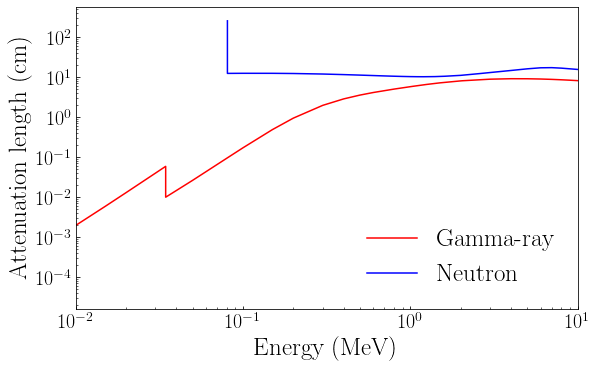

In [18]:
ps.latexify()
fig , ax=plt.subplots(1,1)

ax.plot(e, att,color='red',label='Gamma-ray')
ax.plot(en, attn,color='Blue',label = 'Neutron')
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Attenuation length (cm)')
ax.legend(loc='lower right',frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 10)

ps.format_axes(ax)

plt.savefig('DM_plots/Attenuation.pdf', bbox_inches='tight')